In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import statistics

In [3]:
df = pd.read_excel('./data/gameScores_2015-2024.xlsx')
df

,date,visitor,home,visitor_points,home_points
0,2015-10-03,Charlotte Hornets,Orlando Magic,106,100
1,2015-10-03,New Orleans Pelicans,Indiana Pacers,110,105
2,2015-10-03,Denver Nuggets,LA Clippers,96,103
3,2015-10-04,Charlotte Hornets,Miami Heat,90,77
4,2015-10-04,LA Clippers,Toronto Raptors,73,93
...,...,...,...,...,...
13107,2024-11-05,Portland Trail Blazers,New Orleans Pelicans,118,100
13108,2024-11-05,Toronto Raptors,Denver Nuggets,119,121
13109,2024-11-05,Sacramento Kings,Miami Heat,111,110
13110,2024-11-05,Milwaukee Bucks,Cleveland Cavaliers,114,116


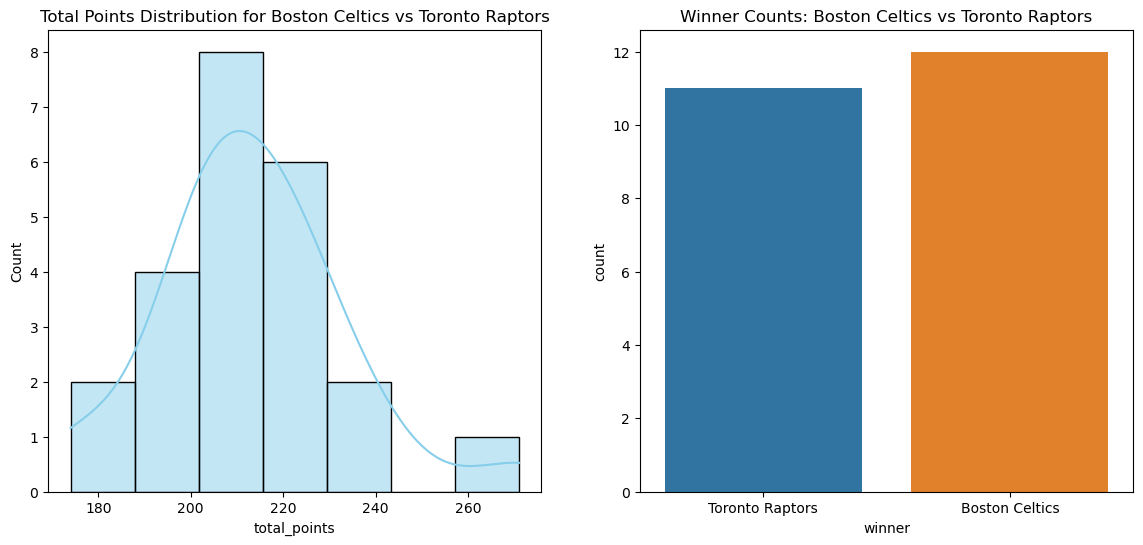

Statistics of Boston Celtics vs Toronto Raptors


Mean: 213.30434782608697
Standard Deviation: 20.298756752365392
------------------------------------
z-score for 224.5: 0.55
z-score for 225.5: 0.60
z-score for 226.5: 0.65
z-score for 227.5: 0.70
z-score for 228.5: 0.75
z-score for 229.5: 0.80
z-score for 230.5: 0.85
z-score for 231.5: 0.90
z-score for 232.5: 0.95
z-score for 233.5: 0.99
z-score for 234.5: 1.04
z-score for 235.5: 1.09
z-score for 236.5: 1.14
z-score for 237.5: 1.19
z-score for 238.5: 1.24


,date,visitor,home,visitor_points,home_points,total_points,winner
733,2016-01-21,Boston Celtics,Toronto Raptors,109,115,224,Toronto Raptors
1120,2016-03-18,Boston Celtics,Toronto Raptors,91,105,196,Toronto Raptors
2083,2017-01-11,Boston Celtics,Toronto Raptors,106,114,220,Toronto Raptors
2375,2017-02-25,Boston Celtics,Toronto Raptors,97,107,204,Toronto Raptors
3765,2018-02-07,Boston Celtics,Toronto Raptors,91,111,202,Toronto Raptors
4136,2018-04-05,Boston Celtics,Toronto Raptors,78,96,174,Toronto Raptors
4461,2018-10-20,Boston Celtics,Toronto Raptors,101,113,214,Toronto Raptors
5361,2019-02-26,Boston Celtics,Toronto Raptors,95,118,213,Toronto Raptors
6427,2019-12-25,Boston Celtics,Toronto Raptors,118,102,220,Boston Celtics
7059,2020-08-07,Boston Celtics,Toronto Raptors,122,100,222,Boston Celtics


In [8]:
def possible_outcome(dataframe, away_team, home_team, first_line): 
    # Filter the dataframe for the specific matchup
    matchup_game = dataframe.loc[(dataframe['visitor'] == away_team) & (dataframe['home'] == home_team)].copy()
    
    # Add a 'total_points' column 
    matchup_game['total_points'] = matchup_game['visitor_points'] + matchup_game['home_points']
    
    # Determine the winner
    matchup_game['winner'] = matchup_game.apply(lambda row: home_team if row['home_points'] > row['visitor_points']  else away_team, axis=1)
    
    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
      
    # Plot total points distribution with a KDE
    sns.histplot(data=matchup_game, x='total_points', kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f'Total Points Distribution for {away_team} vs {home_team}')
    
    # Plot the winner count    
    sns.countplot(data=matchup_game, x='winner', ax=axes[1], hue='winner')
    axes[1].set_title(f'Winner Counts: {away_team} vs {home_team}')
        
    # Display the plots
    plt.show()
    
     # Calculate a z-score from a provided mean and standard deviation
    mean = matchup_game['total_points'].mean()
    standard_deviation = matchup_game['total_points'].std()
   
    # Create array of UNDER/OVER values starting with given first line
    under_over_lines = [first_line + i for i in range(15)]
    
    # Display basic statics of team matchup
    print(f'Statistics of {away_team} vs {home_team}')
    print('\n')
    print(f'Mean: {mean}')
    print(f'Standard Deviation: {standard_deviation}')

    print('------------------------------------')
    # Display the z-scores for each line score
    for line in under_over_lines:
        zscore = statistics.NormalDist(mean, standard_deviation).zscore(line)
        print(f'z-score for {line}: {zscore:.2f}')

    # print('------------------------------------')

    # Find percentage of games between specified range
    # total_games = len(matchup_game)
    # games_in_range = matchup_game[(matchup_game['total_points'] >= lower_bound) & (matchup_game['total_points'] <= upper_bound)]
    # percentage = (len(games_in_range) / total_games) * 100
    # print(f"Percentage of games with total scores between {lower_bound} and {upper_bound}: {percentage:.2f}%")
    # print('------------------------------------')
    
    return matchup_game

away_team = input("Enter the away team: ")
home_team = input("Enter the home team: ")
first_line = float(input("Enter the first line for the over/under bet: "))


possible_outcome(df, away_team, home_team, first_line)